# Working with a DTM

This notebook picks up where the last one left off. Note the compactness of the code.

## Getting the Modules and Data

In [1]:
# IMPORTS
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# PLOT PARAMETERS
plt.rcParams['figure.dpi'] = 300
plt.rcParams["figure.figsize"] = (10,5)


In [2]:

# DATA
# Change the variable/object below to reflect your genre
strings = []

# Now we populate the object with strings
for p in Path(f"../queue/scifi").glob('*.txt'):
    with open(p, mode="r") as f:
        contents = f.read()
        strings.append(contents)

# If we have the same number as we can see in the folder, we got them all
len(strings)

155

## Vectorizing into a DTM

In [ ]:
# Basic vectorizer: no tweaks to parameters
vectorizer = CountVectorizer( min_df=2, max_df = 0.9)

# fit the model to the data 
matrix = vectorizer.fit_transform(strings)

# We'll need these later
vocabulary = vectorizer.get_feature_names_out()

# This will repeat our screenplay count
# but also report our overall vocabulary FOR ALL SCREENPLAYS
matrix.shape

(155, 54106)

### Output Notes

With no parameters, the DTM's shape is 155 rows (screenplays) and 54106 columns (words as features). Introducing and changing the parameters gives the following results:

| min_df | Result |
|--------|--------|
| none   | 54106  |
| 2      | 29480  |
| 3      | 22944  |
|  4     | 19366  |
|  5     | 16956  |
| 6      | 15254  |

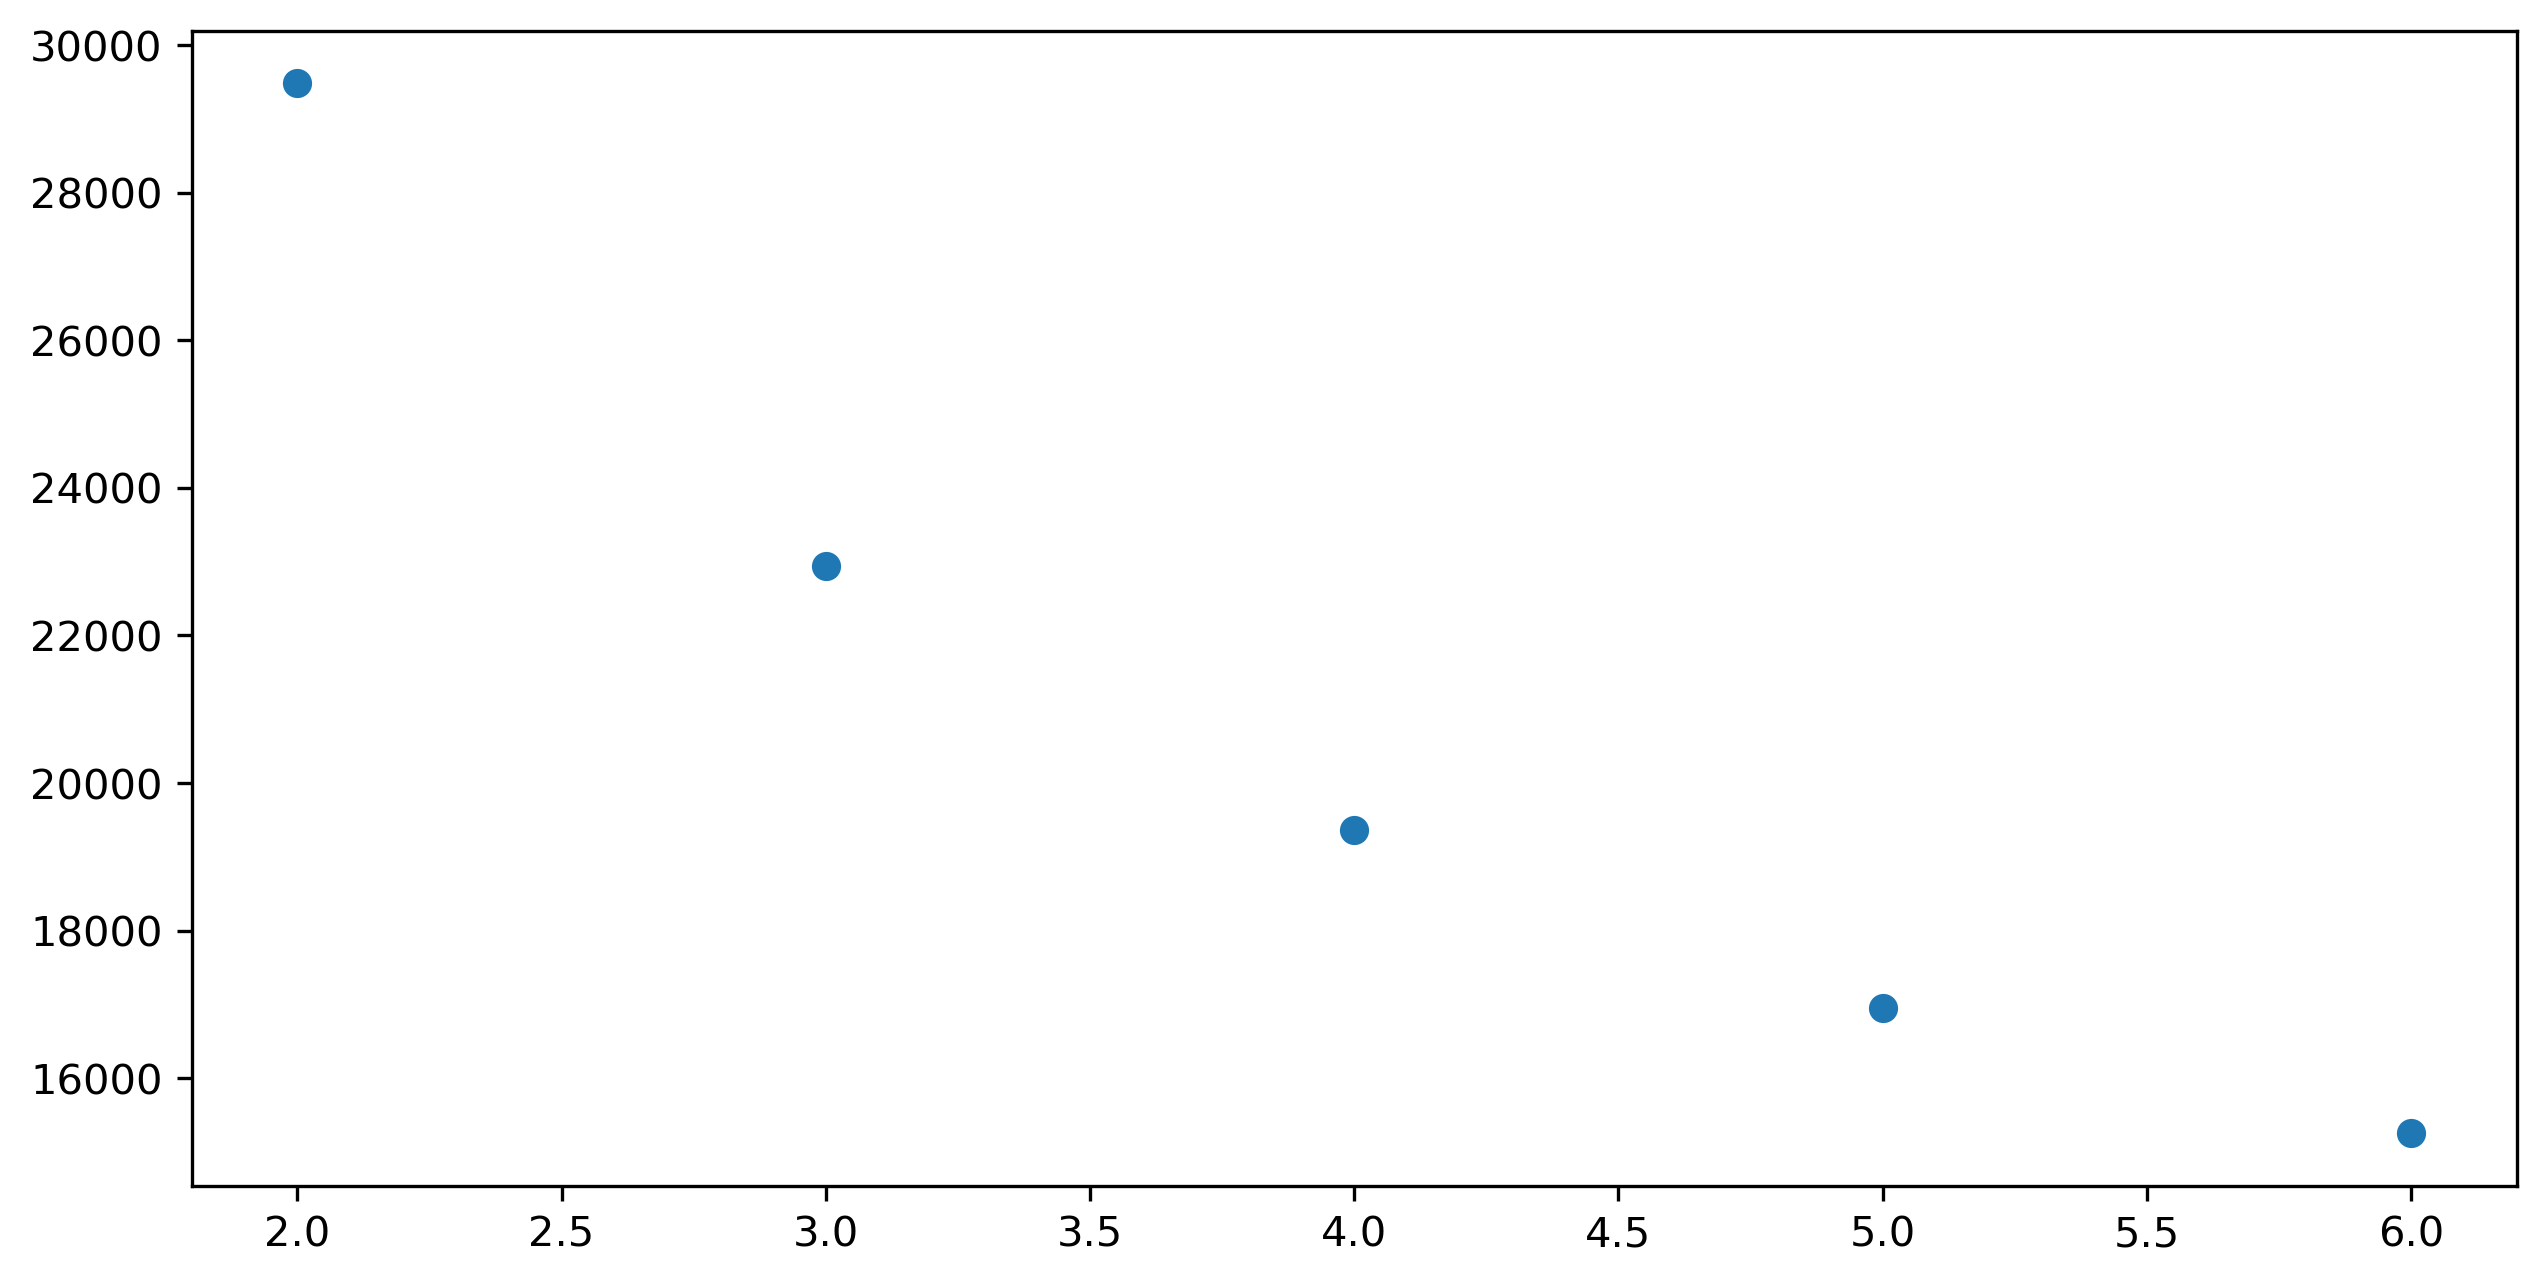

In [4]:
# Get a list of the word counts for each matrix:
heights = []
for i in range(2,7):
    vectorizer = CountVectorizer( min_df = i )
    matrix = vectorizer.fit_transform(strings)
    heights.append(matrix.shape[1])

# Graph the results
x = [ i for i in range(2,7) ]
y = heights

plt.scatter(x, y)

Let's explore the results of changing **max_df**:

| max_df | Result |
|--------|--------|
| none   | 54106  |
| 0.99   | 53904  |
| 0.95   | 53743  |
| 0.9    | 53621  |
| 0.85   | 53488  |

Could I graph this? Yes. Will I? Probably not. The differences are small. Given that sometimes common words can provide interesting signals, I think I will hold onto them.

### Custom Tokenization

Next we're going to build a custom text "pre-processor" that we can use with a variety of Sci-Kit Learn (and perhaps other) functions. By building our own, in effect, tokenizer, we make it possible to be more in control of the input.

In [5]:
def processit(a_string):
    """ Requires nltk """
    # first we lower-case everything
    lowered = a_string.lower()
    # then tokenize
    tokens = word_tokenize(lowered)
    # remove stopwords
    words = [token for token in tokens if token not in stop_words]
    # lemmatize
    lemmas = [lemmatizer.lemmatize(word) for word in words]
    # rejoin the list of lemmas into a string and return
    return " ".join(lemmas)

In [6]:
# Our familiar dance moves:
vectorizer = CountVectorizer(min_df = 2, preprocessor = processit) 
matrix_pp = vectorizer.fit_transform(strings)
vocabulary = vectorizer.get_feature_names_out()

# Check our results
matrix_pp.shape

(155, 25597)

That takes a long time! That's because NLTK is doing a lot of work on each string. What if we want to play with the vectorizer's parameters? Do we really want to loop over the same set of texts doing the same thing each time while adjusting the **min_df** and/or **max_df**?

No. We can preprocess the strings ourselves, using the same function, but simply creating a new list of (processed) strings that we can then feed to the vectorizer.

In [7]:
processed_strings = [ processit(i) for i in strings ]

In [8]:
# Vectorize:
vectorizer = CountVectorizer( min_df = 2 ) 
matrix_processed = vectorizer.fit_transform(processed_strings)
vocabulary = vectorizer.get_feature_names_out()

# Check our results
matrix_processed.shape

(155, 25597)

Same results, but in somewhat less total time. *Makes note to self.*

## Creating and Saving a Dataframe

Now that we have our corpus transformed into a document-term matrix (DTM), it would be nice if we could not only make it more computable but also to make it storable as a file. That way, we need not recreate the DTM every time we want to work with it: we can simply load it from a file. 

In [9]:

# Load up a dataframe with our DTM
df = pd.DataFrame(matrix_processed.toarray(), 
                  columns = vocabulary)

# Check our work:
df.shape
df.head()

,00,000,003,004,00am,01,010,02,0200,03,...,zonked,zoo,zoological,zoom,zoomed,zooming,zulu,zuma,zurich,zzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,10,0,3,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,4,0,0,0,0,0,0


### One More Round

You know what? I do not like those numbers being in there. What if we tokenize using regex that only keeps characters and apostrophes? (You might remember this from the first few weeks of class.) Let's see if we can't get a cleaner DTM. 

***Note**: I can see in the dataframe preview above that there is something like 0200, which might reveal some military dimensions to our science fiction screenplays. I may want to revisit this later...*

Hold on ... we are going to do everything in one cell ... if we can.

In [10]:
# First our revised function that uses regex to tokenize:
def processrx(a_string):
    """ Requires re """
    # Tokenize and lowercase
    words = re.sub("[^a-zA-Z']"," ", a_string).lower().split()
    # lemmatize
    lemmas = [lemmatizer.lemmatize(word) for word in words]
    # rejoin the list of lemmas into a string and return
    return " ".join(lemmas)

# Run our screenplays through the function
processrx_texts = [ processrx(i) for i in strings ]

# Vectorize:
vectorizer_rx = CountVectorizer( min_df = 2 ) 
matrix_rx = vectorizer_rx.fit_transform(processrx_texts)
vocabulary_rx = vectorizer_rx.get_feature_names_out()

# Load up a dataframe with our DTM
df = pd.DataFrame(matrix_rx.toarray(), 
                  columns = vocabulary_rx)

# Check our work:
df.head()

,aa,aaaa,aaaaaaa,aaaaaaaaaa,aaaaaaaah,aaaah,aaaargh,aaah,aaand,aaargh,...,zoo,zoological,zoom,zoomed,zooming,zulu,zuma,zurich,zz,zzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,10,0,3,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0,0


Okay, we will live with those results. For now, at leat. (Later we may revisit all this based on things we find, either cool things or weird things. You never know.)

In the mean time, it would be nice to have the names of the films included in our dataframe, so we need to label the rows. Adding a column is easy, and so is making that column the index for each row -- so long as we do not have two screenplays with the same name. That could happen, but here we are going to use filenames, which we know have to be unique. It's also to get those. 

This involves just three moves: 
- **get** a list of titles from the filenames
- **add** that list as a column to the dataframe
- **set** that column to be the index

In [11]:
# First we need to get the file names from the files
titles= []

for p in Path('../queue/scifi/').glob('*.txt'):
    with open(p, mode="r", encoding="utf-16") as f:
        title = p.name[:-4]
        titles.append(title)

# Check
print(titles[50:55])

['spiderman', 'cowboysaliens', 'ghostbusters2', 'g.i.joetheriseofcobra', 'cube']


In [12]:
# Create a column in our data frame
# and then populate it with our list of titles
df["title"] = titles

# Set the title to be the first column (the index) of the dataframe
df.set_index('title', inplace = True)

# See it:
df.head()

,aa,aaaa,aaaaaaa,aaaaaaaaaa,aaaaaaaah,aaaah,aaaargh,aaah,aaand,aaargh,...,zoo,zoological,zoom,zoomed,zooming,zulu,zuma,zurich,zz,zzz
title,,,,,,,,,,,,,,,,,,,,,
xmen,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
priest,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
gamer,0,1,0,0,0,0,0,0,0,0,...,0,0,10,0,3,0,0,0,0,0
startrekgenerations,0,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,0
startreknemesis,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0,0


Having done all this work, let's save it to a file. We are saving to a CSV file, but you can also save to an Excel file, if that's more useful to you. (If you do want to try saving to Excel, please also save to a CSV file: it will be easier to load into a dataframe in our next session.)

In [ ]:
df.to_csv('../data/scifi.csv')

In [13]:
import os

# Size of the CSV
csv_size = os.path.getsize('../data/scifi.csv')

# Size of the directory
texts_size = sum(d.stat().st_size for d in os.scandir('../queue/scifi') if d.is_file())

# Let's compare the sizes in megabytes (millions of bytes)
print(csv_size/10**6, texts_size/10**6)

7.854411 30.172799
